[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/obss/sahi/blob/main/demo/inference_for_yolov5.ipynb)

## 0. Preperation

- Install latest version of SAHI and YOLOv5:

In [1]:
!pip install -U torch==1.11.0 torchvision==0.12.0 pillow==8.* sahi yolov5

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 750.6/750.6 MB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 39.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.0/101.0 KB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 956.3/956.3 KB 38.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.5/97.5 KB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.3/88.3 KB 7.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.5/135.5 KB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 KB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 21.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.7/55.7 KB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.6/79

In [2]:
import os
os.getcwd()

'/content'

- Import required modules:

In [3]:
# arrange an instance segmentation model for test
from sahi.utils.yolov5 import (
    download_yolov5s6_model,
)

# import required functions, classes
from sahi import AutoDetectionModel
from sahi.utils.cv import read_image
from sahi.utils.file import download_from_url
from sahi.predict import get_prediction, get_sliced_prediction, predict
from IPython.display import Image

- Download a yolov5 model and two test images:

In [4]:
# download YOLOV5S6 model to 'models/yolov5s6.pt'
yolov5_model_path = 'models/yolov5s6.pt'
download_yolov5s6_model(destination_path=yolov5_model_path)

# download test images into demo_data folder
download_from_url('https://raw.githubusercontent.com/obss/sahi/main/demo/demo_data/small-vehicles1.jpeg', 'demo_data/small-vehicles1.jpeg')
download_from_url('https://raw.githubusercontent.com/obss/sahi/main/demo/demo_data/terrain2.png', 'demo_data/terrain2.png')

## 1. Standard Inference with a YOLOv5 Model

- Instantiate a detection model by defining model weight path and other parameters:

In [5]:
detection_model = AutoDetectionModel.from_pretrained(
    model_type='yolov5',
    model_path=yolov5_model_path,
    confidence_threshold=0.3,
    device='cuda:0'
)

- Perform prediction by feeding the get_prediction function with an image path and a DetectionModel instance:

In [6]:
result = get_prediction("demo_data/small-vehicles1.jpeg", detection_model)

- Or perform prediction by feeding the get_prediction function with a numpy image and a DetectionModel instance:

In [7]:
result = get_prediction(read_image("demo_data/small-vehicles1.jpeg"), detection_model)

- Visualize predicted bounding boxes and masks over the original image:

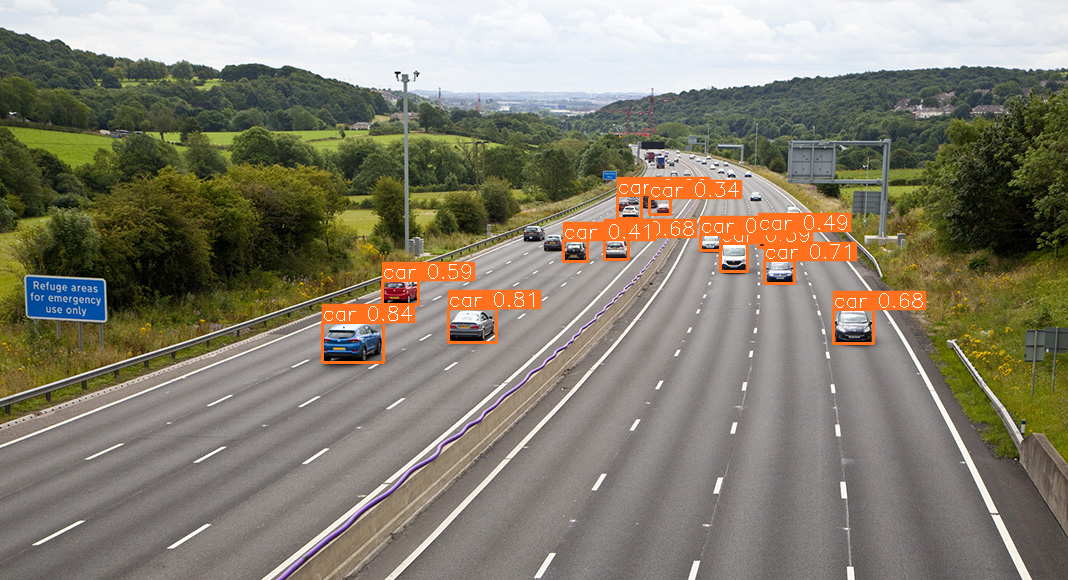

In [8]:
result.export_visuals(export_dir="demo_data/")

Image("demo_data/prediction_visual.png")

## 2. Sliced Inference with a YOLOv5 Model

- To perform sliced prediction we need to specify slice parameters. In this example we will perform prediction over slices of 256x256 with an overlap ratio of 0.2:

In [9]:
result = get_sliced_prediction(
    "demo_data/small-vehicles1.jpeg",
    detection_model,
    slice_height = 256,
    slice_width = 256,
    overlap_height_ratio = 0.2,
    overlap_width_ratio = 0.2
)

Performing prediction on 15 number of slices.


- Visualize predicted bounding boxes and masks over the original image:

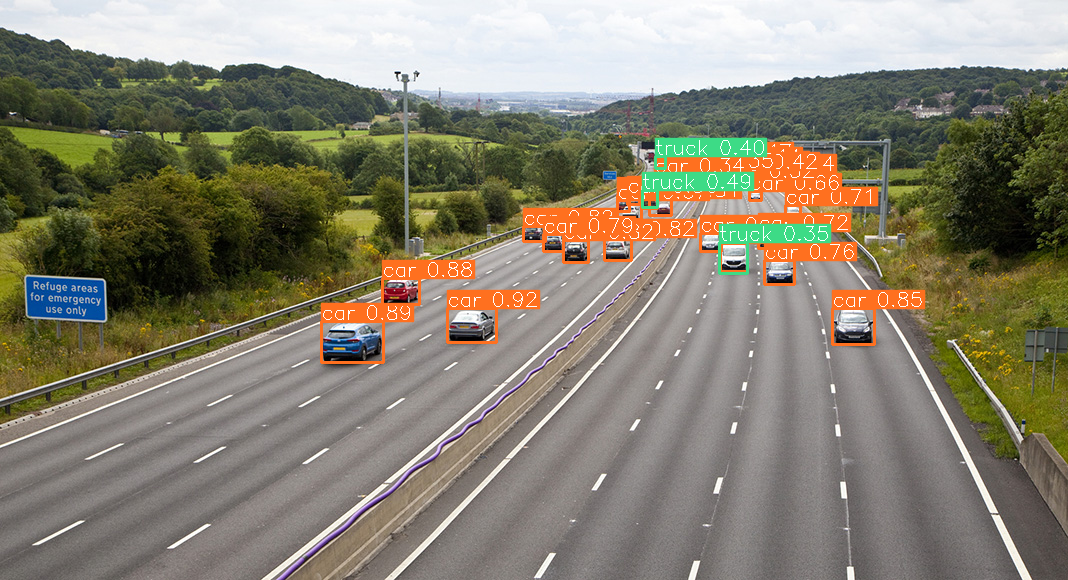

In [10]:
result.export_visuals(export_dir="demo_data/")

Image("demo_data/prediction_visual.png")

## 3. Prediction Result

- Predictions are returned as [sahi.prediction.PredictionResult](sahi/prediction.py), you can access the object prediction list as:

In [11]:
object_prediction_list = result.object_prediction_list

In [12]:
object_prediction_list[0]

ObjectPrediction<
    bbox: BoundingBox: <(447.55752182006836, 308.252685546875, 496.90765380859375, 342.8026428222656), w: 49.35013198852539, h: 34.549957275390625>,
    mask: None,
    score: PredictionScore: <value: 0.9154329299926758>,
    category: Category: <id: 2, name: car>>

- ObjectPrediction's can be converted to [COCO annotation](https://cocodataset.org/#format-data) format:

In [13]:
result.to_coco_annotations()[:3]

[{'image_id': None,
  'bbox': [447.55752182006836,
   308.252685546875,
   49.35013198852539,
   34.549957275390625],
  'score': 0.9154329299926758,
  'category_id': 2,
  'category_name': 'car',
  'segmentation': [],
  'iscrowd': 0,
  'area': 1705},
 {'image_id': None,
  'bbox': [321.43294525146484,
   321.90821838378906,
   62.17200469970703,
   40.92445373535156],
  'score': 0.8879777193069458,
  'category_id': 2,
  'category_name': 'car',
  'segmentation': [],
  'iscrowd': 0,
  'area': 2544},
 {'image_id': None,
  'bbox': [382.0502624511719,
   278.4272003173828,
   36.96442413330078,
   26.353561401367188],
  'score': 0.8796822428703308,
  'category_id': 2,
  'category_name': 'car',
  'segmentation': [],
  'iscrowd': 0,
  'area': 974}]

- ObjectPrediction's can be converted to [COCO prediction](https://github.com/i008/COCO-dataset-explorer) format:

In [15]:
result.to_coco_predictions(image_id=1)[:3]

[{'image_id': 1,
  'bbox': [447.55752182006836,
   308.252685546875,
   49.35013198852539,
   34.549957275390625],
  'score': 0.9154329299926758,
  'category_id': 2,
  'category_name': 'car',
  'segmentation': [],
  'iscrowd': 0,
  'area': 1705},
 {'image_id': 1,
  'bbox': [321.43294525146484,
   321.90821838378906,
   62.17200469970703,
   40.92445373535156],
  'score': 0.8879777193069458,
  'category_id': 2,
  'category_name': 'car',
  'segmentation': [],
  'iscrowd': 0,
  'area': 2544},
 {'image_id': 1,
  'bbox': [382.0502624511719,
   278.4272003173828,
   36.96442413330078,
   26.353561401367188],
  'score': 0.8796822428703308,
  'category_id': 2,
  'category_name': 'car',
  'segmentation': [],
  'iscrowd': 0,
  'area': 974}]

In [17]:
pip install -U imantics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for imantics: filename=imantics-0.1.12-py3-none-any.whl size=16030 sha256=763742c61d810e9512a048d6bc437e4568e1be53f0edd89f4664850ba3d07a93
  Stored in directory: /root/.cache/pip/wheels/45/65/ec/8f8f231fa40bc5d47798df399f65aea84d2e3a0ea296f81506
Successfully built imantics


- ObjectPrediction's can be converted to [imantics](https://github.com/jsbroks/imantics) annotation format:

In [18]:
result.to_imantics_annotations()[:3]

In [20]:
pip install -U fiftyone

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.3/7.3 MB 34.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 KB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.8/37.8 MB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.2/40.2 KB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.6/63.6 KB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 492.1/492.1 KB 35.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.9/68.9 KB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 192.5/192.5 KB 19.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 564.5/564.5 KB 42.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.2/56.2 KB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.8/226.8 KB 21.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━

- ObjectPrediction's can be converted to [fiftyone](https://github.com/voxel51/fiftyone) detection format:

In [21]:
result.to_fiftyone_detections()[:3]

Migrating database to v0.20.0


INFO:fiftyone.migrations.runner:Migrating database to v0.20.0


[<Detection: {
     'id': '64207bd8a1e5a6da33b7520a',
     'attributes': {},
     'tags': [],
     'label': 'car',
     'bounding_box': [
         0.4190613500187906,
         0.5314701474946121,
         0.04620798875330093,
         0.059568891854121765,
     ],
     'mask': None,
     'confidence': 0.9154329299926758,
     'index': None,
 }>, <Detection: {
     'id': '64207bd8a1e5a6da33b7520b',
     'attributes': {},
     'tags': [],
     'label': 'car',
     'bounding_box': [
         0.3009671772017461,
         0.5550141696272225,
         0.05821348754654217,
         0.07055940299198546,
     ],
     'mask': None,
     'confidence': 0.8879777193069458,
     'index': None,
 }>, <Detection: {
     'id': '64207bd8a1e5a6da33b7520c',
     'attributes': {},
     'tags': [],
     'label': 'car',
     'bounding_box': [
         0.35772496484192123,
         0.4800468970989359,
         0.034610884019944554,
         0.04543717482994342,
     ],
     'mask': None,
     'confidence': 0.8

## 4. Batch Prediction

- Set model and directory parameters:

In [23]:
model_type = "yolov5"
model_path = yolov5_model_path
model_device = 'cuda:0'
model_confidence_threshold = 0.4

slice_height = 256
slice_width = 256
overlap_height_ratio = 0.2
overlap_width_ratio = 0.2

source_image_dir = "demo_data/"

- Perform sliced inference on given folder:

In [26]:
predict(
    model_type=model_type,
    model_path=model_path,
    model_device=model_device,
    model_confidence_threshold=model_confidence_threshold,
    source=source_image_dir,
    slice_height=slice_height,
    slice_width=slice_width,
    overlap_height_ratio=overlap_height_ratio,
    overlap_width_ratio=overlap_width_ratio,
)

There are 10 listed files in folder: demo_data/


Performing inference on images:   0%|          | 0/10 [00:00<?, ?it/s]

Performing prediction on 8 number of slices.


Performing inference on images:  10%|█         | 1/10 [00:04<00:36,  4.01s/it]

Prediction time is: 3965.16 ms
Performing prediction on 2 number of slices.


Performing inference on images:  20%|██        | 2/10 [00:05<00:18,  2.31s/it]

Prediction time is: 1089.91 ms
Performing prediction on 20 number of slices.


Performing inference on images:  30%|███       | 3/10 [00:16<00:45,  6.44s/it]

Prediction time is: 11234.59 ms
Performing prediction on 4 number of slices.


Performing inference on images:  40%|████      | 4/10 [00:19<00:30,  5.06s/it]

Prediction time is: 2905.53 ms
Performing prediction on 15 number of slices.


Performing inference on images:  50%|█████     | 5/10 [00:26<00:28,  5.78s/it]

Prediction time is: 7003.35 ms
Performing prediction on 12 number of slices.


Performing inference on images:  60%|██████    | 6/10 [00:34<00:25,  6.49s/it]

Prediction time is: 7801.84 ms
Performing prediction on 6 number of slices.


Performing inference on images:  70%|███████   | 7/10 [00:38<00:17,  5.72s/it]

Prediction time is: 4056.92 ms
Performing prediction on 15 number of slices.


Performing inference on images:  80%|████████  | 8/10 [00:52<00:16,  8.31s/it]

Prediction time is: 13735.55 ms


Performing inference on images:  80%|████████  | 8/10 [00:52<00:16,  8.31s/it]

Performing prediction on 120 number of slices.


Performing inference on images:  80%|████████  | 8/10 [01:53<00:16,  8.31s/it]

Prediction time is: 61366.55 ms


Performing inference on images:  90%|█████████ | 9/10 [01:54<00:25, 25.07s/it]

Performing prediction on 8 number of slices.


Performing inference on images: 100%|██████████| 10/10 [01:57<00:00, 11.79s/it]

Prediction time is: 3505.88 ms
Prediction results are successfully exported to runs/predict/exp3
